# Data Exploration

---

## Import packages

In [159]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib

---

## Setup Folders
As always we start with specifying the data paths:

In [160]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'Andreas')

processed_dir = proj_dir / 'processed'
data_dir = proj_dir / 'output'

---

## Load Data
We load the data from the last notebook;

In [161]:
#load data frame
df_name = data_dir / 'caulobacter_combined_data.csv'
df = pd.read_csv(df_name, index_col=0)

#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df.head()

,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,old_pole,...,fluo1,fluo2,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id
0,0,0,-1,0,-1,-1,-1,0,[ 4 706],[ 2 706],...,470.422222,411.577778,705.777778,2.955556,0.0,0,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0
1,0,0,-1,0,-1,-1,-1,1,[ 4 700],[ 3 700],...,473.651163,400.348837,700.255814,2.813953,0.0,1,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0
2,0,0,-1,0,-1,-1,-1,2,[ 3 705],[ 0 699],...,458.216216,372.648649,702.243243,2.405405,0.0,2,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0
3,0,0,-1,0,-1,-1,-1,3,[ 2 704],[ 2 703],...,453.787879,371.757576,703.606061,2.242424,0.0,3,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0
4,0,0,-1,0,-1,-1,-1,4,[ 3 704],[ 2 704],...,473.738095,368.166667,704.047619,2.642857,0.0,4,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0


Text(0.5, 0, 'life time of cell [frames]')

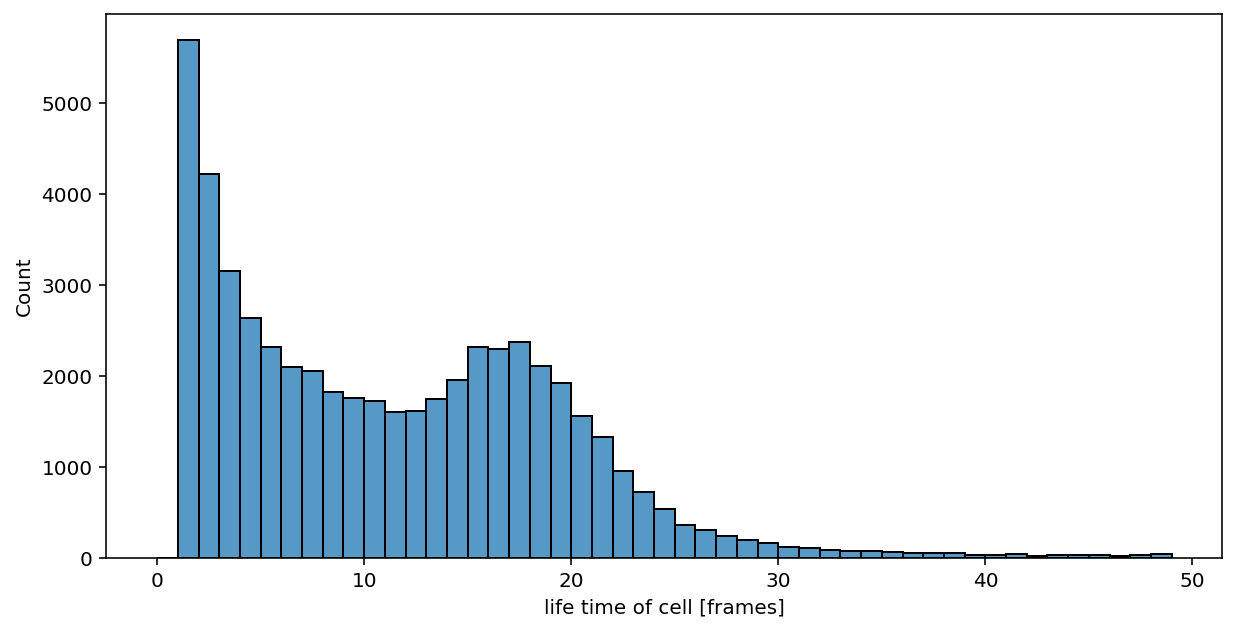

In [162]:
#plot life time of cells
ax = sns.histplot(data=df.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')

---

## Remove incomplete lineages

We only consider full lineages (mothers & daughters tracked)

dropping 295077 lineages, 49.8% remaining


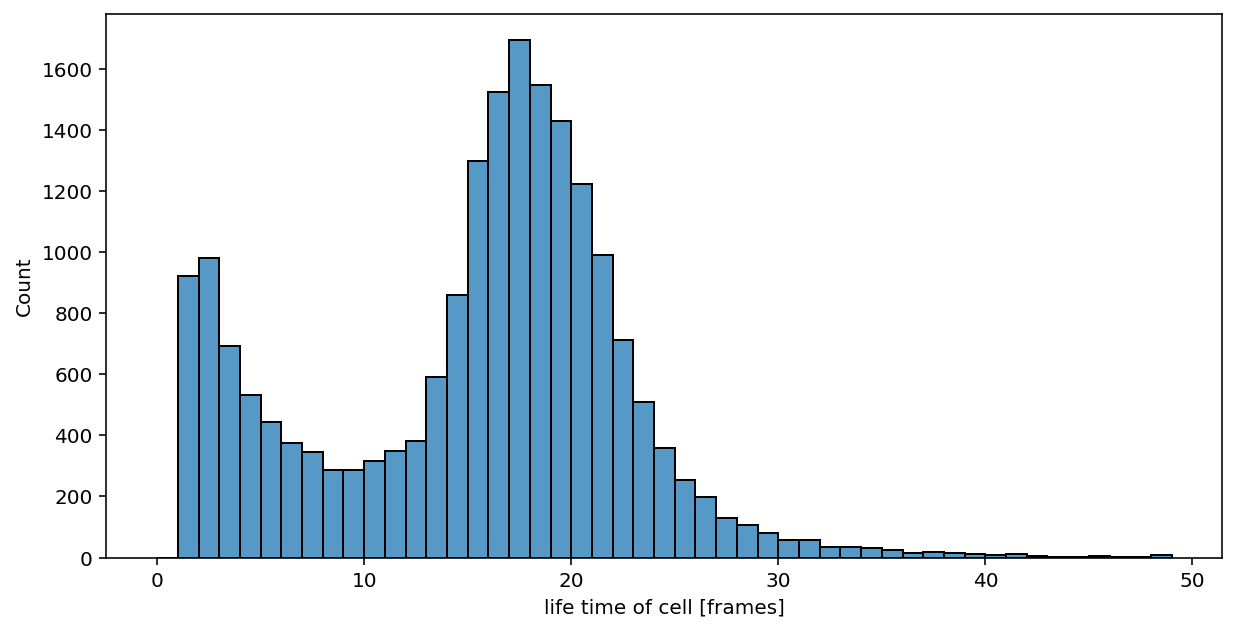

In [163]:
#remove incomplete lineages
has_mom = df["id_par"] > -1
has_d1 = df["id_d1"] > -1
has_d2 = df["id_d2"] > -1

df_filt1 = df.loc[has_mom & has_d1 & has_d2]
ax = sns.histplot(data=df_filt1.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')
print('dropping %i lineages, %.1f%% remaining' % (df.shape[0]-df_filt1.shape[0], df_filt1.shape[0]/df.shape[0]*100))


---

## Remove lineages that are too short

We only consider lineages that are around for at least 30 minutes (7 frames)

dropping 11546 lineages, 47.8% remaining


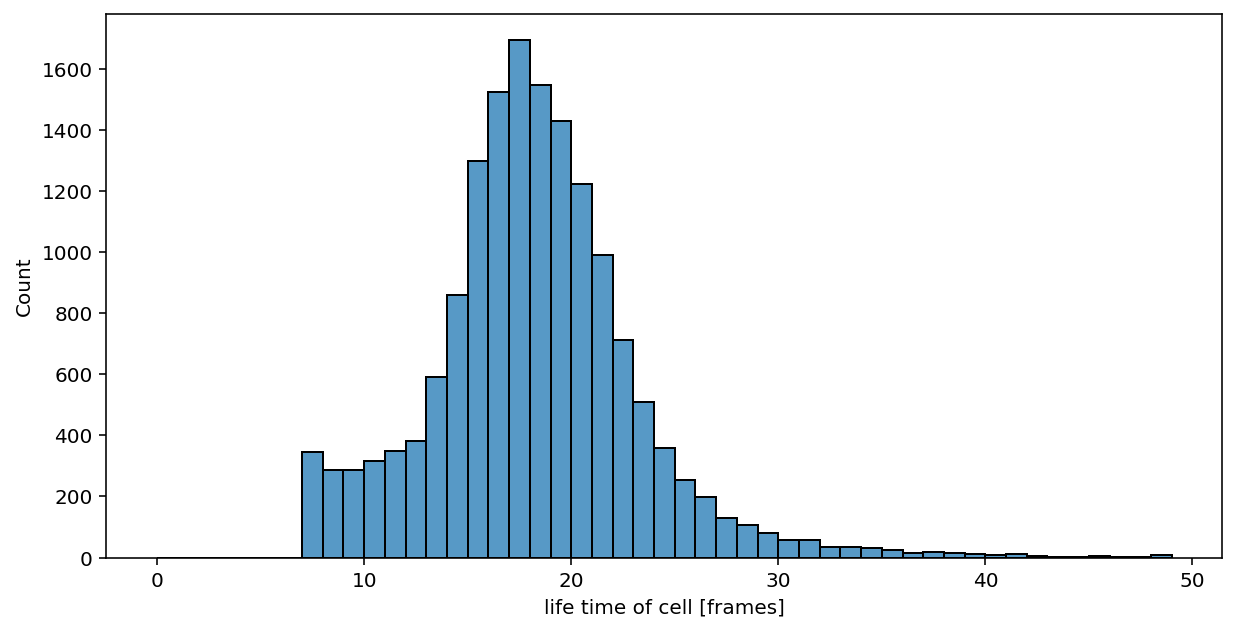

In [164]:
# remove lineages that are too short:
min_num_frames = 7
df_filt2 = df_filt1.groupby('uni_id').filter(lambda x: len(x) >= min_num_frames)
ax = sns.histplot(data=df_filt2.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')
print('dropping %i lineages, %.1f%% remaining' % (df_filt1.shape[0]-df_filt2.shape[0], df_filt2.shape[0]/df.shape[0]*100))


## Filter out length inconsistencies

Next we filter out lineages where the length changes too much.

We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$

We allow for a max increase of 1.08 (e.q. to $t_d=45$  min), and a max decrease of 0.92.

<AxesSubplot:xlabel='rel_dl', ylabel='Count'>

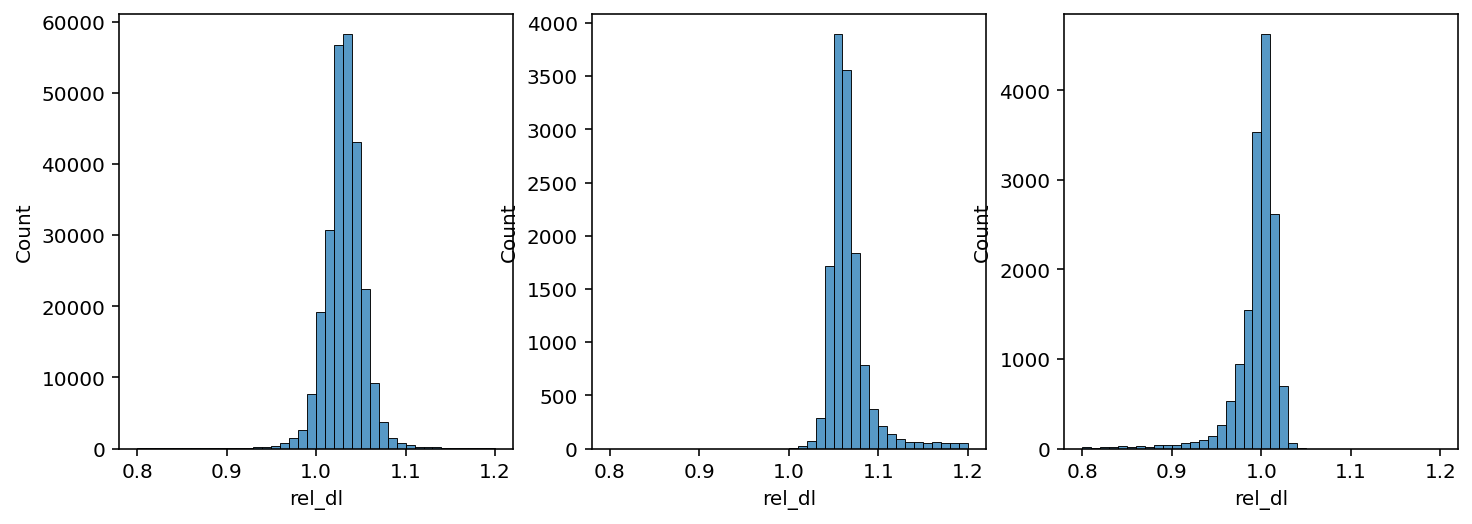

In [165]:
#calc length change
dl = df_filt2.groupby('uni_id')['length'].diff()
df_filt2['rel_dl'] = (df_filt2['length'] + dl)/df_filt2['length']
max_dl = df_filt2.groupby('uni_id')['rel_dl'].max()
min_dl = df_filt2.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_filt2, x='rel_dl', bins=np.linspace(0.8,1.2,41))
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41))
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41))


In [166]:
# filter on length change
max_dl = 1.08 #(eq. to td=45min)
min_dl = 0.92

df_filt3 = df_filt2.groupby('uni_id').filter(lambda x: (x['rel_dl'].min() > min_dl) & (x['rel_dl'].max() < max_dl))
print('dropping %i lineages, %.1f%% remaining' % (df_filt2.shape[0]-df_filt3.shape[0], df_filt3.shape[0]/df.shape[0]*100))


dropping 76419 lineages, 34.8% remaining


## Save filtered data

In [167]:
out_name = processed_dir / 'caulobacter_combined_filtered_data.csv'
df_filt3.to_csv(out_name)

## Analyze statistics

Text(0.5, 0, 'number of lineages per move')

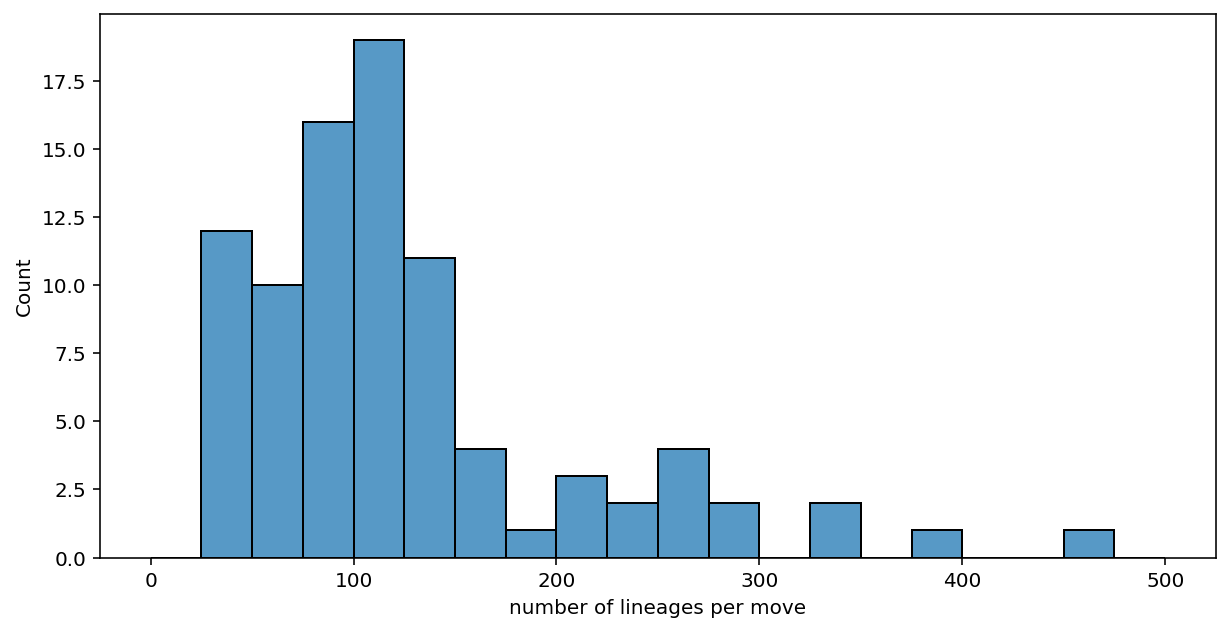

In [168]:
first_frame = df_filt3.groupby('uni_id').first()
num_lin_per_exp =first_frame.groupby('movie_name').size()


ax = sns.histplot(num_lin_per_exp, bins=np.linspace(0,500,21))
ax.set_xlabel('number of lineages per move')

In [169]:
num_lin_per_strain =first_frame.groupby('strain').size()
num_lin_per_strain.head(n=18)


strain
AKS1088     818
AKS1089     545
AKS1090     971
AKS1091    1378
AKS1092    1760
AKS1093     508
AKS1094     394
AKS1095     523
AKS1096     779
AKS1097     456
AKS1098     417
AKS1099     455
AKS1101     512
AKS1102     265
AKS1103     493
AKS1104     303
AKS1105     274
AKS1106     414
dtype: int64

<AxesSubplot:xlabel='strain'>

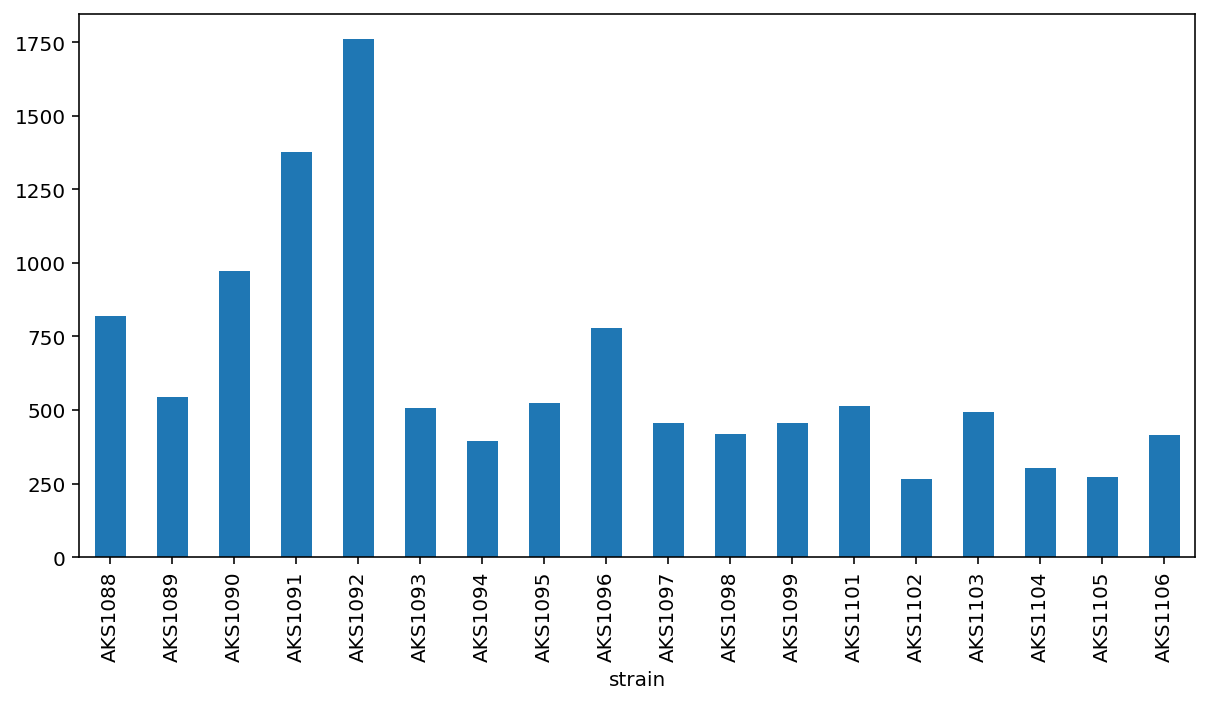

In [170]:
num_lin_per_strain.plot(kind='bar')

## Filter out cells for which we also have a sibling

In [171]:

paired_dfs = []
grouped = df_filt3.groupby('movie_name')
for name, group in grouped:
    dfsub = group.groupby('id_cell').filter(lambda x: x['id_sib'].unique() in group['id_cell'].unique())
    paired_dfs.append(dfsub)
    
df_paired= pd.concat(paired_dfs)    
df_paired.head()    
    

,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,old_pole,...,fluo2,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,rel_dl
156,3,7,6,3,8,430,236,3,[14 55],[14 74],...,494.236686,65.923077,13.449704,1.0,0,AKS1088,AKS1088_TL01_01,0,AKS1088-0-7,NaN
157,3,7,6,3,8,430,236,4,[14 55],[15 78],...,493.152542,66.677966,14.203390,1.0,1,AKS1088,AKS1088_TL01_01,0,AKS1088-0-7,1.035281
158,3,7,6,3,8,430,236,5,[16 52],[18 79],...,493.712707,65.585635,15.701657,1.0,2,AKS1088,AKS1088_TL01_01,0,AKS1088-0-7,1.072101
159,3,7,6,3,8,430,236,6,[15 53],[18 79],...,498.333333,65.446237,15.521505,1.0,3,AKS1088,AKS1088_TL01_01,0,AKS1088-0-7,1.002187
160,3,7,6,3,8,430,236,7,[16 55],[18 76],...,495.578680,65.487310,16.309645,1.0,4,AKS1088,AKS1088_TL01_01,0,AKS1088-0-7,1.034236


## Check division consistency

In [172]:
def check_division(x, group, maxdl=1.1, mindl=0.8):
    
    x['id_sib'].unique() in group['id_cell'].unique()
    
    
    sib_idx = group['id_cell']==x['id_sib'].iloc[0]
    par_idx = group['id_cell']==x['id_par'].iloc[0]

    #get length
    len_cel = x['length'].iloc[0]
    len_sib = group.loc[sib_idx, 'length'].iloc[0]
    len_par = group.loc[sib_idx, 'length'].iloc[-1]
    
    dl = (len_cel + len_sib) / len_par
    
    return (dl < maxdl) & (dl > mindl)


def analyze_division(cell, movie, df):
    
    sib_idx = movie['id_cell']==cell['id_sib'].iloc[0]
    
    par_name = '%s-%i-%i' % (cell['strain'].iloc[0], cell['replicate'].iloc[0], cell['id_par'].iloc[0])
    par_idx = df['uni_id']==par_name

    #get length
    len_cel = cell['length'].iloc[0]
    len_sib = movie.loc[sib_idx, 'length'].iloc[0]
    len_par = df.loc[par_idx, 'length'].iloc[-1]
    
    dl = (len_cel + len_sib) / len_par
    
    return dl
    

In [175]:
dl = []
movies = df_paired.groupby('movie_name')
for name, movie in movies:
    cells = group.groupby('id_cell')
    for name, cell in cells:
        dl.append(analyze_division(cell, movie, df))
    


IndexError: single positional indexer is out-of-bounds

<AxesSubplot:xlabel='strain'>

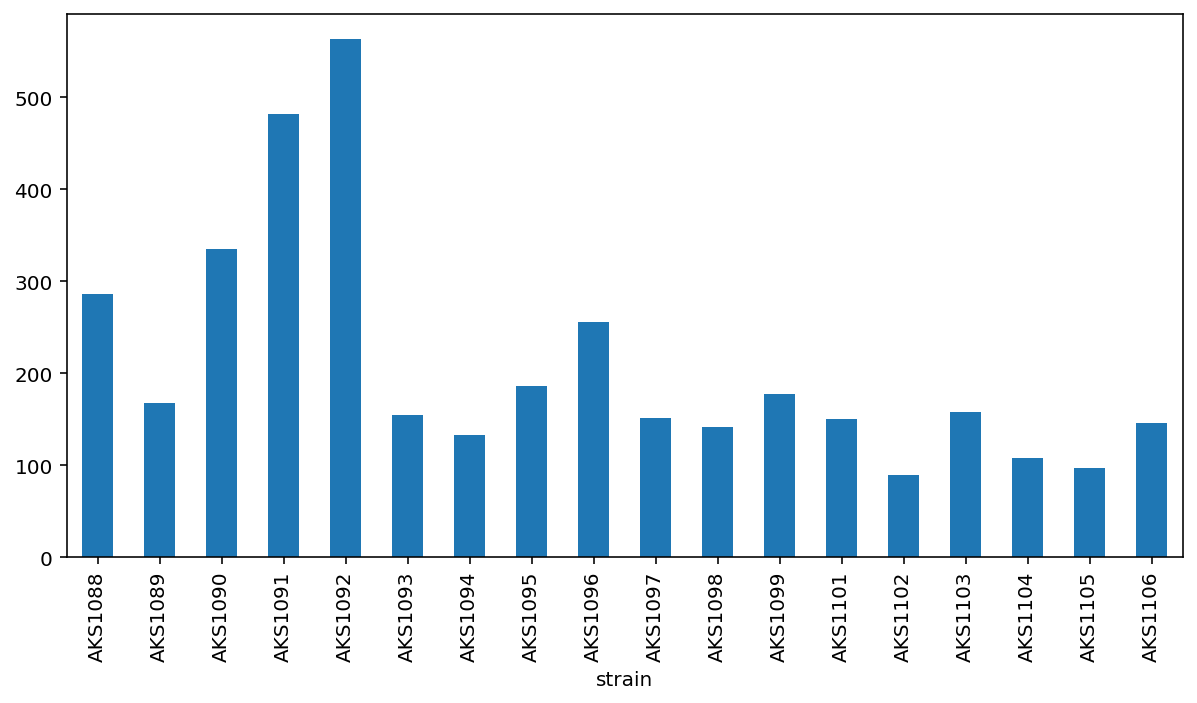

In [145]:
first_frame = df_paired.groupby('uni_id').first()
num_lin_per_strain = first_frame.groupby('strain').size() / 2
num_lin_per_strain.head(n=18)
num_lin_per_strain.plot(kind='bar')


In [ ]:
num_lin_per_strain

strain
AKS1088    286.0
AKS1089    168.0
AKS1090    335.0
AKS1091    482.0
AKS1092    563.0
AKS1093    154.0
AKS1094    133.0
AKS1095    186.0
AKS1096    256.0
AKS1097    151.0
AKS1098    142.0
AKS1099    177.0
AKS1101    150.0
AKS1102     89.0
AKS1103    158.0
AKS1104    108.0
AKS1105     97.0
AKS1106    146.0
dtype: float64

## Save paired data

In [147]:
out_name = processed_dir / 'caulobacter_combined_filtered_paired_data.csv'
df_paired.to_csv(out_name)